In [ ]:
!pip install sklearn
!pip install pandas
!pip install statsmodels
!pip install seaborn
!pip install keras-tcn

In [2]:
# https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import Input, Model
from keras.layers import Dense
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tcn import TCN
from copy import copy


Using TensorFlow backend.


In [3]:
train_split_size = 0.60
milk = pd.read_csv('monthly-milk-production-pounds-p.csv', index_col=0, parse_dates=True)
labels = pd.read_csv('../data/dengue_labels_train.csv', parse_dates=True)
sj_data = labels[labels.city == 'sj'][['total_cases']]

data = sj_data


def split(df, train_split_size):
    train_size = int(math.ceil(len(df)*train_split_size))
    val_size = int(math.floor((len(df)*(1-train_split_size))))
    return df[0:train_size], df[train_size:train_size+val_size]


def ar_data(values, lookback_window=12):
    x, y = [], []
    for i in range(lookback_window, len(values)):
        x.append(values[i - lookback_window:i])
        y.append(values[i])
    x = np.array(x)
    y = np.array(y)
    return x, y

## Separate splits and perform data augmentation

In [4]:
train, val = split(data, train_split_size)
train = train.values
val = val.values

print(train.shape)

lookback_window = 180  # months.
x_train, y_train = ar_data(train, lookback_window)
x_val, y_val = ar_data(val, lookback_window)


print(x_train.shape)
x_aug = copy(x_train)
y_aug = copy(y_train)

num_aug=20
std = 2
for i in range(num_aug):
    x_perturbed = x_train + np.random.normal(0, std, size=x_train.shape)
    x_aug = np.concatenate((x_aug, x_perturbed))

    y_perturbed = y_train + np.random.normal(0, std, size=y_train.shape)
    y_aug = np.concatenate((y_aug, y_perturbed))


x_aug = x_aug.clip(min=0)
y_aug = y_aug.clip(min=0)
    
# x_aug = np.log(1+x_aug)
# y_aug = np.log(1+y_aug)
# x_val_log = np.log(1+x_val)
# y_val_log = np.log(1+y_val)

(562, 1)
(382, 180, 1)


## Model with causal convolutional DNN

In [88]:
i = Input(shape=(lookback_window, 1))
print(i.shape)
m = TCN(nb_filters=32,
        nb_stacks=1,
        kernel_size=4,
        dilations=[2 ** i for i in range(9)])(i)
m = Dense(1, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])

# model.summary()

model.compile('adam', 'mae')

print('Train...')

validation_data = (x_val, y_val)
model.fit(x_aug, y_aug, epochs=60, verbose=2, validation_data=validation_data)



(?, 180, 1)
Train...


ValueError: Error when checking input: expected input_2 to have shape (180, 1) but got array with shape (180, 23)

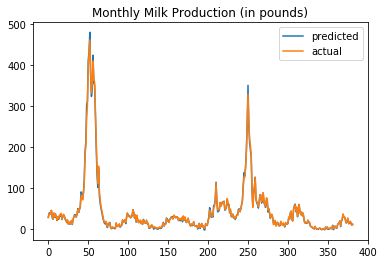

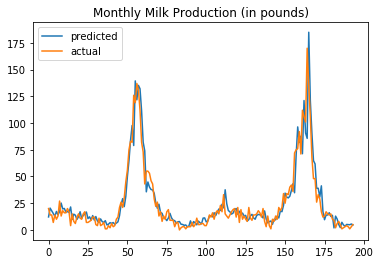

In [6]:
p = model.predict(x_train)

plt.plot(p)
plt.plot(y_train)
plt.title('Weekly Dengue Cases')
plt.legend(['predicted', 'actual'])
plt.show()

p = model.predict(x_val)

plt.plot(p)
plt.plot(y_val)
plt.title('Weekly Dengue Cases')
plt.legend(['predicted', 'actual'])
plt.show()


## Forecasting

(382, 180, 1)
VAL MAE = 40.24226804123711


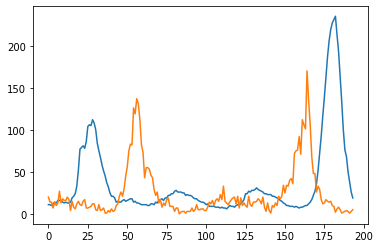

In [8]:

print(x_train.shape)
x =  copy(x_train[-1].reshape(1, lookback_window, 1))

y_pred = []
nexty = y_train[-1]

# print(x)
# print(nexty)
for i in range(len(y_val)):
    
    x[0][0:lookback_window-1] = x[0][1:lookback_window]
    x[0][lookback_window-1] = nexty
    nexty = int(model.predict(x))
    y_pred.append(nexty)

y_pred = np.array(y_pred)
error = mean_absolute_error(y_val, y_pred)

print("VAL MAE = {}".format(error))
plt.plot(y_pred)
plt.plot(y_val)

